# Tutorial: Flash Unit Model with Modular Property Package

<img src='flash.png' width="100" height="100">

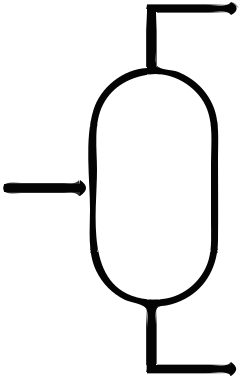

In [99]:
from IPython.core.display import SVG
SVG(filename='flash.svg')

## Learning Outcomes

- Demonstrate use of the flash unit model in IDAES


## Problem Statement

In this example, we will be flashing a liquid feed stream of benzene and toluene to form a liquid outlet stream and a vapor outlet stream. The inlet conditions are as follows:

**Inlet:**

Flow Rate = 100 mol/s

Mole Fraction (Benzene) = 0.6

Mole Fraction (Toluene) = 0.4

Temperature = 298 K

Pressure = 101325 Pa


For more details, please refer to the IDAES documentation: https://idaes-pse.readthedocs.io/en/stable

## Setting up the problem in IDAES

In the following cell, we will be importing the necessary components from Pyomo and IDAES.

In [100]:
# Import objects from pyomo package 
from pyomo.environ import ConcreteModel, value

# Import the solver
from idaes.core.solvers import get_solver

# Import the main FlowsheetBlock from IDAES. The flowsheet block will contain the unit model
from idaes.core import FlowsheetBlock

# Import the flash unit model
from idaes.models.unit_models import Flash

# Import idaes logger to set output levels
import idaes.logger as idaeslog

# Import the modular property package to create a property block for the flowsheet
from idaes.models.properties.modular_properties.base.generic_property import GenericParameterBlock

# Import the BT_Ideal property package to create a configuration file for the GenericParameterBlock
from idaes.models.properties.modular_properties.examples.BT_ideal import configuration

# Import the degrees_of_freedom function from the idaes.core.util.model_statistics package
# DOF = Number of Model Variables - Number of Model Constraints
from idaes.core.util.model_statistics import degrees_of_freedom

# Create the ConcreteModel and the FlowsheetBlock objects, and attach the flowsheet block to it.
m = ConcreteModel()

m.fs = FlowsheetBlock(dynamic=False) # dynamic or ss flowsheet needs to be specified here

# Add properties parameter block to the flowsheet with the appropriate configuration file
m.fs.properties = GenericParameterBlock(**configuration)


In the following cell, we will be creating the flash unit model, assigning a property package to it, and determining the degrees of freedom associated with the flash unit model.

In [101]:
# Create an instance of the flash unit, attaching it to the flowsheet
# Specify that the property package to be used with the flash is the one we created earlier

m.fs.flash = Flash(property_package=m.fs.properties)

# Call the degrees_of_freedom function, get initial DOF
DOF_initial = degrees_of_freedom(m)
print('The initial degrees of freedom are: {0}'.format(DOF_initial))

The initial degrees of freedom are: 7


In [102]:
assert DOF_initial == 7

In the following cell, we will be specifying the inlet conditions for the flash block and ensuring that there are zero degrees of freedom. It will be assumed that the flash unit has a heat duty of 100,000 W and no pressure change.

In [103]:
# Fix the inlet conditions

# Inlet stream
m.fs.flash.inlet.flow_mol.fix(100) # converting to mol/s as unit basis is mol/s
m.fs.flash.inlet.mole_frac_comp[0, "benzene"].fix(0.6)
m.fs.flash.inlet.mole_frac_comp[0, "toluene"].fix(0.4)
m.fs.flash.inlet.pressure.fix(101325) # Pa
m.fs.flash.inlet.temperature.fix(353) # K

# Flash unit variables
m.fs.flash.heat_duty.fix(1e5) # W
m.fs.flash.deltaP.fix(0)


# Call the degrees_of_freedom function, get final DOF
DOF_final = degrees_of_freedom(m)
print('The final degrees of freedom is: {0}'.format(DOF_final))

The final degrees of freedom is: 0


In [104]:
assert DOF_final == 0

### Flowsheet Initialization

In [105]:
# Initialize the flowsheet, and set the output at WARNING
m.fs.flash.initialize(outlvl=idaeslog.WARNING)

### Obtaining Simulation Results

In [106]:
# Solve the simulation using the IDAES solver
# Note: If the degrees of freedom = 0, we have a square problem
solver = get_solver()
result = solver.solve(m, tee=True)

Ipopt 3.13.2: nlp_scaling_method=gradient-based
tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale

In [107]:
from pyomo.opt import TerminationCondition, SolverStatus

# Check if termination condition is optimal
assert result.solver.termination_condition == TerminationCondition.optimal
assert result.solver.status == SolverStatus.ok

### View Results

In [108]:
# Display output report
m.fs.flash.report()


Unit : fs.flash                                                            Time: 0.0
------------------------------------------------------------------------------------
    Unit Performance

    Variables: 

    Key             : Value      : Units  : Fixed : Bounds
          Heat Duty : 1.0000e+05 :   watt :  True : (None, None)
    Pressure Change :     0.0000 : pascal :  True : (None, None)

------------------------------------------------------------------------------------
    Stream Table
                                    Units         Inlet    Vapor Outlet  Liquid Outlet
    Total Molar Flowrate         mole / second     100.00            -             -  
    Total Mole Fraction benzene  dimensionless    0.60000            -             -  
    Total Mole Fraction toluene  dimensionless    0.40000            -             -  
    Temperature                         kelvin     353.00            -             -  
    Pressure                            pascal 1.0132e+05      

In [109]:
import pytest

# # Check liquid outlet results
assert value(m.fs.flash.liq_outlet.flow_mol[0]) == pytest.approx(97.559, rel=1e-3)
assert value(m.fs.flash.liq_outlet.mole_frac_comp[0, "benzene"]) == pytest.approx(0.59531, rel=1e-3)
assert value(m.fs.flash.liq_outlet.mole_frac_comp[0, "toluene"]) == pytest.approx(0.40469, rel=1e-3)
assert value(m.fs.flash.liq_outlet.pressure[0]) == pytest.approx(101325, rel=1e-3)
assert value(m.fs.flash.liq_outlet.temperature[0]) == pytest.approx(362.69, rel=1e-3)


# Check vapor outlet results
assert value(m.fs.flash.vap_outlet.flow_mol[0]) == pytest.approx(2.4408, rel=1e-3)
assert value(m.fs.flash.vap_outlet.mole_frac_comp[0, "benzene"]) == pytest.approx(0.7873, rel=1e-6)
assert value(m.fs.flash.vap_outlet.mole_frac_comp[0, "toluene"]) == pytest.approx(0.2127, rel=1e-6)
assert value(m.fs.flash.vap_outlet.pressure[0]) == pytest.approx(101325, rel=1e-6)
assert value(m.fs.flash.vap_outlet.temperature[0]) == pytest.approx(362.69, rel=1e-6)


AssertionError: 